## Exercise 2

In this exercise, we will predict the two income classes in the adult dataset (The file "adult.csv" is also on Moodle). 

Answer the following questions:
1. Clean the `income` variable such that it has only two values
2. Select as set of minimum two feature variables you want to use to predict `income`. Do the necessary transformation of these variables.
3. Create X and y dataset and split the datasets into training and testing sets
4. Train a KNN classifier to predict the variable `income` based on the feature variables selected in 2 - try out some different Ks 
5. Train a logistic regression classifier to predict the variable `income` based on the feature variables selected in 2 and compare it to the KNN classifier.
6. Train a decision tree classifier to predict the variable `income` based on the feature variables selected in 2 and compare it to the previous classifiers.
7. Train a random forest classifier to predict the variable `income` based on the feature variables selected in 2 and compare it to the previous classifiers.
8. Train a AdaBoost classifier to predict the variable `income` based on the feature variables selected in 2 and compare it to the previous classifiers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Cleaning
First, let's load the data and clean the income variable.

In [2]:
# Load the dataset
adult_data = pd.read_csv('adult.csv')

# Check unique values in income column
print("Unique values in income column before cleaning:")
print(adult_data['income'].unique())

# Clean the income variable - handle both possible formats with and without leading space
adult_data['income'] = adult_data['income'].replace({
    ' <=50K': 0, 
    ' >50K': 1,
    '<=50K': 0, 
    '>50K': 1,
    ' <=50K.': 0, 
    ' >50K.': 1,
    '<=50K.': 0, 
    '>50K.': 1
})

# Verify the cleaning worked
print("\nUnique values in income column after cleaning:")
print(adult_data['income'].unique())
print("\nValue counts in income column:")
print(adult_data['income'].value_counts())

Unique values in income column before cleaning:
['<=50K' '>50K' '<=50K.' '>50K.']

Unique values in income column after cleaning:
[0 1]

Value counts in income column:
income
0    37155
1    11687
Name: count, dtype: int64


C:\Users\victo\AppData\Local\Temp\ipykernel_11368\2394445411.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adult_data['income'] = adult_data['income'].replace({


## 2. Feature Selection and Transformation
We'll select numerical features and perform necessary transformations.

In [3]:
# Select features for prediction
features = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']
X = adult_data[features]
y = adult_data['income']


print("\nMissing values in features:")
print(X.isnull().sum())
print("\nMissing values in target:")
print(y.isnull().sum())


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)


Missing values in features:
age               0
education-num     0
hours-per-week    0
capital-gain      0
capital-loss      0
dtype: int64

Missing values in target:
0


## 3. Train-Test Split
Split the data into training and testing sets.

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## 4. KNN Classifier
Let's try different values of K and find the optimal one.

In [ ]:
# Function to evaluate KNN for different K values
def evaluate_knn(k_range):
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        k_scores.append(scores.mean())
    return k_scores

# Test different K values
k_range = range(1, 31)
k_scores = evaluate_knn(k_range)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K')
plt.ylabel('Cross-validated Accuracy')
plt.title('KNN Classifier Performance for Different K Values')
plt.show()

# Train KNN with best K
best_k = k_range[np.argmax(k_scores)]
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
knn_pred = knn_best.predict(X_test)

print(f"\nBest K value: {best_k}")
print("\nKNN Classification Report:")
print(classification_report(y_test, knn_pred))

## 5. Logistic Regression
Now let's implement and evaluate logistic regression.

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88     11109
           1       0.69      0.39      0.50      3544

    accuracy                           0.81     14653
   macro avg       0.76      0.67      0.69     14653
weighted avg       0.80      0.81      0.79     14653



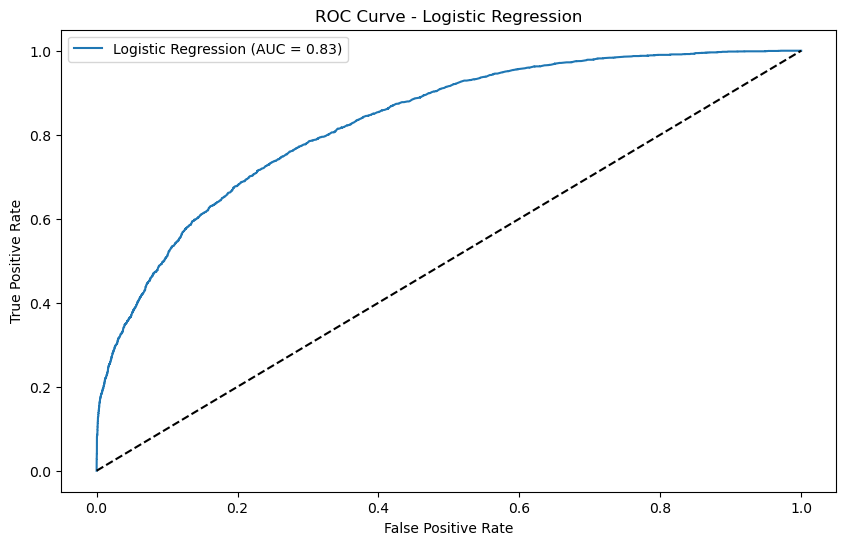

In [7]:
# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))

# ROC curve for logistic regression
lr_probs = lr_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

## 6. Decision Tree Classifier
Let's implement and evaluate a decision tree classifier.

In [8]:
# Train decision tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     11109
           1       0.70      0.46      0.56      3544

    accuracy                           0.82     14653
   macro avg       0.77      0.70      0.72     14653
weighted avg       0.81      0.82      0.81     14653



## 7. Random Forest Classifier
Now let's implement and evaluate a random forest classifier.

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     11109
           1       0.70      0.48      0.57      3544

    accuracy                           0.83     14653
   macro avg       0.78      0.71      0.73     14653
weighted avg       0.81      0.83      0.81     14653



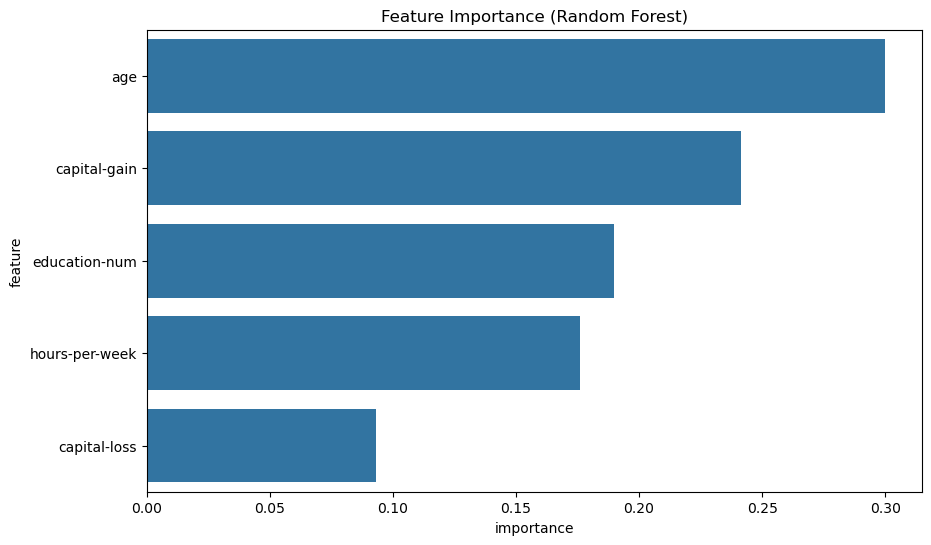

In [9]:
# Train random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Feature importance plot
plt.figure(figsize=(10, 6))
importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
sns.barplot(x='importance', y='feature', data=importance.sort_values('importance', ascending=False))
plt.title('Feature Importance (Random Forest)')
plt.show()

## 8. AdaBoost Classifier
Finally, let's implement and evaluate an AdaBoost classifier.

In [10]:
# Train AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)
ada_pred = ada_model.predict(X_test)

print("AdaBoost Classification Report:")
print(classification_report(y_test, ada_pred))

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     11109
           1       0.77      0.43      0.55      3544

    accuracy                           0.83     14653
   macro avg       0.80      0.69      0.72     14653
weighted avg       0.82      0.83      0.81     14653



## Model Comparison
Let's compare all models using their accuracy scores.


Model Comparison:
                 Model  Accuracy
0                  KNN  0.823927
1  Logistic Regression  0.810755
2        Decision Tree  0.822971
3        Random Forest  0.825019
4             AdaBoost  0.830683


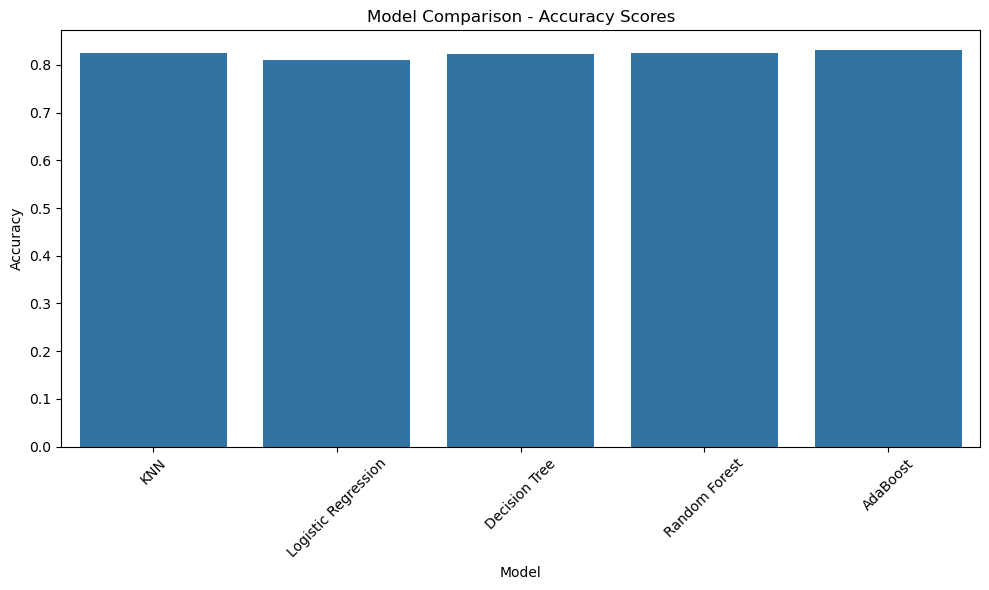

In [11]:
# Compare all models
models = {
    'KNN': knn_best,
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'AdaBoost': ada_model
}

# Calculate accuracy for each model
results = []
for name, model in models.items():
    accuracy = accuracy_score(y_test, model.predict(X_test))
    results.append({'Model': name, 'Accuracy': accuracy})

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.xticks(rotation=45)
plt.title('Model Comparison - Accuracy Scores')
plt.tight_layout()
plt.show()

We see that all models perform about the same, but with a slight edge to Adaboost